## Carga de datos y preparación inical ##



--- Cargando Datos ---
Datos cargados correctamente desde archivos CSV.
- train_df: 3960 filas, 82 columnas
- test_df: 20 filas, 59 columnas

Dimensiones de train_labeled_df (después de eliminar nulos en 'sii'): (2736, 82)
Distribución de la variable objetivo ('sii') en train_labeled_df:
sii
0    0.582602
1    0.266813
2    0.138158
3    0.012427
Name: proportion, dtype: float64


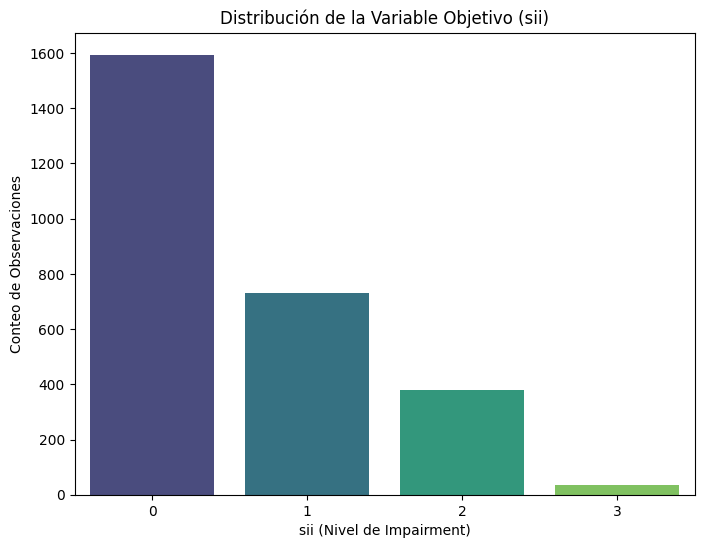


Dimensiones iniciales de X_train (todas las features compartidas antes del filtrado de fugas/nulos): (2736, 58)
Dimensiones iniciales de y_train: (2736,)
Dimensiones iniciales de X_test (todas las features compartidas antes del filtrado de fugas/nulos): (20, 58)


In [10]:
# Parte 1: Carga de Datos y Preparación Inicial

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import joblib
import warnings

# Ignorar warnings para una salida más limpia
warnings.filterwarnings('ignore')
TARGET_COL = 'sii'

print("--- Cargando Datos ---")
train_df = pd.read_csv('./dataset/train.csv')
test_df = pd.read_csv('./dataset/test.csv')
data_dict_df = pd.read_csv('./dataset/data_dictionary.csv')
sample_submission_df = pd.read_csv('./dataset/sample_submission.csv')
print("Datos cargados correctamente desde archivos CSV.")

# Crear copias para evitar SettingWithCopyWarning
train_df_copy = train_df.copy()
test_df_copy = test_df.copy()

print(f"- train_df: {train_df_copy.shape[0]} filas, {train_df_copy.shape[1]} columnas")
print(f"- test_df: {test_df_copy.shape[0]} filas, {test_df_copy.shape[1]} columnas")

# Eliminar filas con nulos en 'sii' (variable objetivo) del conjunto de entrenamiento
train_labeled_df = train_df_copy.dropna(subset=[TARGET_COL]).copy()
print(f"\nDimensiones de train_labeled_df (después de eliminar nulos en '{TARGET_COL}'): {train_labeled_df.shape}")

# Convertir 'sii' a tipo entero si no lo está ya, para asegurar compatibilidad con modelos de clasificación
train_labeled_df[TARGET_COL] = train_labeled_df[TARGET_COL].astype(int)

# Distribución de la variable objetivo
print(f"Distribución de la variable objetivo ('{TARGET_COL}') en train_labeled_df:")
print(train_labeled_df[TARGET_COL].value_counts(normalize=True))

# --- Visualización 1: Distribución de la Variable Objetivo ---
plt.figure(figsize=(8, 6))
sns.countplot(x=TARGET_COL, data=train_labeled_df, palette='viridis')
plt.title(f'Distribución de la Variable Objetivo ({TARGET_COL})')
plt.xlabel(f'{TARGET_COL} (Nivel de Impairment)')
plt.ylabel('Conteo de Observaciones')
plt.show()

# --- CRÍTICO: Definición inicial de X_train, y_train, X_test ---
# Definir aquí las variables X_train, y_train, X_test ANTES de cualquier filtrado de columnas
# Se usarán todas las columnas de train_labeled_df excepto 'id' y el TARGET_COL como features iniciales
initial_features_train = [col for col in train_labeled_df.columns if col not in ['id', TARGET_COL]]
initial_features_test = [col for col in test_df_copy.columns if col not in ['id']]

# Asegurarse de que X_train solo tenga las columnas que también están en test_df_copy (excluyendo id)
# Esto es un paso de saneamiento previo a la detección de fugas para que el set inicial sea consistente
# Las exclusiones de fuga y nulos se harán en la Parte 2.
common_initial_features = list(set(initial_features_train) & set(initial_features_test))
common_initial_features.sort() # Para consistencia

X_train = train_labeled_df[common_initial_features].copy()
y_train = train_labeled_df[TARGET_COL].astype(int).copy() # Asegurarse de que y_train sea int
X_test = test_df_copy[common_initial_features].copy()

print(f"\nDimensiones iniciales de X_train (todas las features compartidas antes del filtrado de fugas/nulos): {X_train.shape}")
print(f"Dimensiones iniciales de y_train: {y_train.shape}")
print(f"Dimensiones iniciales de X_test (todas las features compartidas antes del filtrado de fugas/nulos): {X_test.shape}")


# Procesamiento de datos y Selección de caracteristicas #


--- Deep Leakage Detection ---
Buscando características con correlación anormalmente alta con 'sii'...
No se encontraron características numéricas con correlación extremadamente alta con 'sii' (umbral > 0.9).

--- Agregando Verificación Agresiva de Fuga de Datos (Mapeo Directo) ---
  DETECTADA FUGA: Columna 'BIA-BIA_SMM' mapea directamente a 'sii'.
    Ejemplos de mapeo:
      BIA-BIA_SMM  sii
1566      11.3825    0
1658      11.7991    0
3600      12.1372    1
2928      12.5903    0
210       12.6901    0
  DETECTADA FUGA: Columna 'BIA-BIA_TBW' mapea directamente a 'sii'.
    Ejemplos de mapeo:
      BIA-BIA_TBW  sii
2476      20.5892    0
2523      21.6173    0
3275      21.7241    0
2942      21.7776    1
2430      22.0463    1


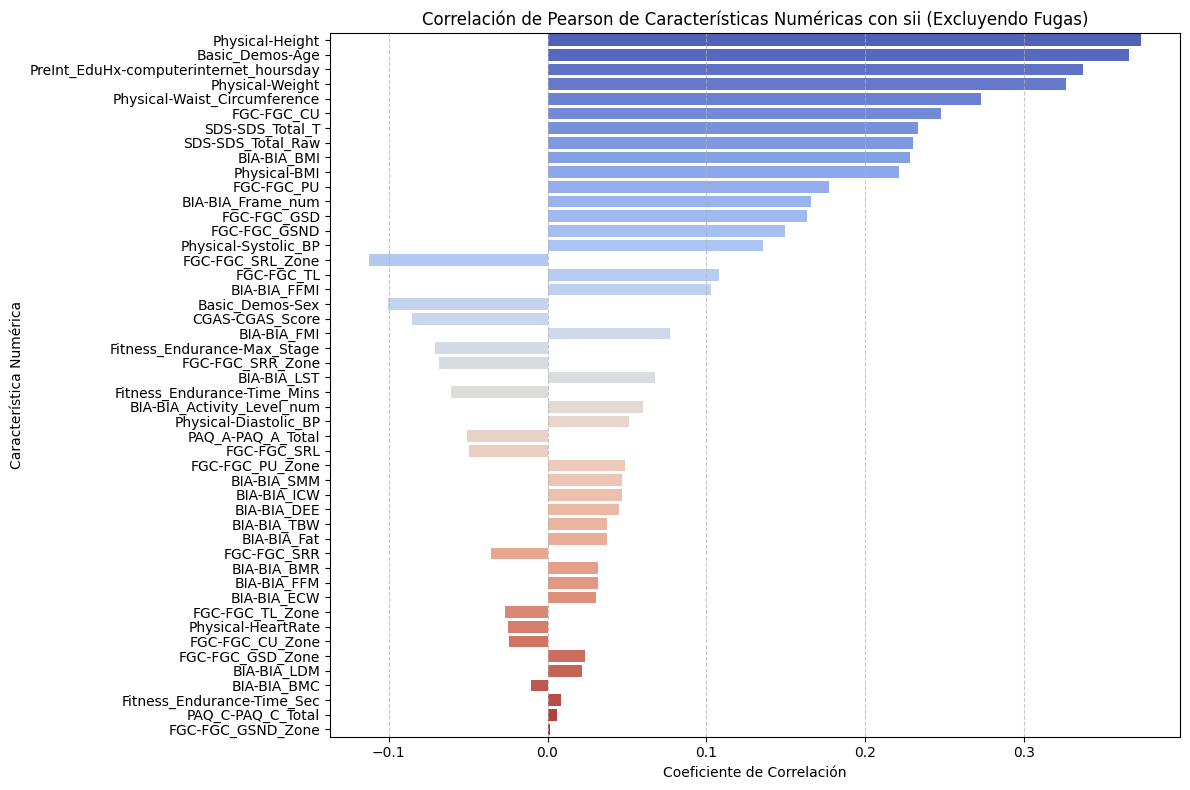


--- Preprocesamiento de Datos (Selección de Características) ---

Columnas excluidas explícitamente del conjunto de características: ['BIA-BIA_SMM', 'BIA-BIA_TBW', 'PCIAT-PCIAT_01', 'PCIAT-PCIAT_02', 'PCIAT-PCIAT_03', 'PCIAT-PCIAT_04', 'PCIAT-PCIAT_05', 'PCIAT-PCIAT_06', 'PCIAT-PCIAT_07', 'PCIAT-PCIAT_08', 'PCIAT-PCIAT_09', 'PCIAT-PCIAT_10', 'PCIAT-PCIAT_11', 'PCIAT-PCIAT_12', 'PCIAT-PCIAT_13', 'PCIAT-PCIAT_14', 'PCIAT-PCIAT_15', 'PCIAT-PCIAT_16', 'PCIAT-PCIAT_17', 'PCIAT-PCIAT_18', 'PCIAT-PCIAT_19', 'PCIAT-PCIAT_20', 'PCIAT-PCIAT_Total', 'PCIAT-Season', 'SDS-SDS_Total_Raw', 'SDS-SDS_Total_T', 'id', 'sii']
Número de columnas de características FINALES y LIMPIAS para modelado: 54
Lista de columnas de características FINALES y LIMPIAS: ['BIA-BIA_Activity_Level_num', 'BIA-BIA_BMC', 'BIA-BIA_BMI', 'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM', 'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_Frame_num', 'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST', 'BIA-Season', 'Basic_D

In [11]:
# Parte 2: Detección de Fugas de Datos y Selección Inicial de Características

print("\n--- Deep Leakage Detection ---")
print("Buscando características con correlación anormalmente alta con 'sii'...")

# Asegurarse de que 'sii' sea numérica para el cálculo de correlación
train_labeled_df_numeric_sii = train_labeled_df.copy()
train_labeled_df_numeric_sii[TARGET_COL] = pd.to_numeric(train_labeled_df_numeric_sii[TARGET_COL], errors='coerce')

numeric_cols_for_corr = train_labeled_df_numeric_sii.select_dtypes(include=np.number).columns.tolist()
if TARGET_COL in numeric_cols_for_corr:
    numeric_cols_for_corr.remove(TARGET_COL)

high_corr_features = {}
if numeric_cols_for_corr:
    # Calcular correlación de Pearson y revisar el valor absoluto
    correlations = train_labeled_df_numeric_sii[numeric_cols_for_corr + [TARGET_COL]].corr()[TARGET_COL]
    for feature, corr_value in correlations.drop(TARGET_COL).abs().items():
        if corr_value > 0.9: # Umbral para correlación "extremadamente alta"
            high_corr_features[feature] = corr_value

    if high_corr_features:
        print("\n¡ALERTA DE FUGA DE DATOS POTENCIAL! Características con correlación muy alta con 'sii':")
        for feature, corr_value in high_corr_features.items():
            print(f"- {feature}: {corr_value:.4f}")
        print("Estas características son fuertes candidatas a ser eliminadas.")
    else:
        print("No se encontraron características numéricas con correlación extremadamente alta con 'sii' (umbral > 0.9).")
else:
    print("No hay columnas numéricas adecuadas para el cálculo de correlación (o solo 'sii').")


# --- Agregando Verificación Agresiva de Fuga de Datos (Mapeo Directo) ---
print("\n--- Agregando Verificación Agresiva de Fuga de Datos (Mapeo Directo) ---")
leaking_cols_by_direct_mapping = []
for col in train_labeled_df.columns:
    if col == TARGET_COL or col == 'id' or 'PCIAT' in col: # Ignorar columnas ya conocidas o el ID
        continue

    # Verificar si cada valor único de la característica mapea a UN SOLO valor único de sii
    mapping_check = train_labeled_df.groupby(col)[TARGET_COL].nunique()

    # Si todos los valores únicos de la característica corresponden a un solo valor de sii, es una fuga
    # Y debe tener más de un valor único para ser considerada una característica útil
    if (mapping_check == 1).all() and len(mapping_check) > 1:
        leaking_cols_by_direct_mapping.append(col)
        print(f"  DETECTADA FUGA: Columna '{col}' mapea directamente a '{TARGET_COL}'.")
        print("    Ejemplos de mapeo:")
        print(train_labeled_df[[col, TARGET_COL]].drop_duplicates().sort_values(by=col).head())

if not leaking_cols_by_direct_mapping:
    print("  No se detectaron columnas con mapeo directo y único a 'sii'.")

# --- Visualización 2: Correlación de Características Numéricas con el Target ---
# Solo para las columnas numéricas que NO sean el target o las ya excluidas por direct mapping
numeric_cols_for_viz = [col for col in numeric_cols_for_corr if col not in leaking_cols_by_direct_mapping]

# --- Visualización 2: Correlación de Características Numéricas con el Target ---
# Usar las columnas numéricas finales que se incluirán en el modelado
# Es crucial que 'final_feature_cols' ya esté definida y que contenga solo las columnas limpias
# Primero, identifiquemos las columnas numéricas de 'final_feature_cols'
numeric_cols_for_final_viz = X_train.select_dtypes(include=np.number).columns.tolist() # Usar X_train que ya está limpio

if numeric_cols_for_final_viz:
    plt.figure(figsize=(12, 8))
    # Calcular las correlaciones (Pearson)
    # Usar train_labeled_df_numeric_sii para el cálculo de correlación, pero solo con las columnas limpias
    correlations_to_target = train_labeled_df_numeric_sii[numeric_cols_for_final_viz + [TARGET_COL]].corr()[TARGET_COL]
    # Eliminar la correlación de sii consigo misma
    correlations_to_target = correlations_to_target.drop(TARGET_COL)
    # Ordenar por valor absoluto para ver las más influyentes
    correlations_to_target = correlations_to_target.sort_values(key=abs, ascending=False)

    sns.barplot(x=correlations_to_target.values, y=correlations_to_target.index, palette='coolwarm')
    plt.title(f'Correlación de Pearson de Características Numéricas con {TARGET_COL} (Excluyendo Fugas)')
    plt.xlabel('Coeficiente de Correlación')
    plt.ylabel('Característica Numérica')
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
else:
    print("\nNo hay suficientes columnas numéricas en las características finales para generar el gráfico de correlación.")

# ... (el resto del código de la Parte 2)


print("\n--- Preprocesamiento de Datos (Selección de Características) ---")

# --- PASO CRÍTICO PARA EVITAR LA FUGA DE DATOS (REVISADO Y REFORZADO) ---

# 1. Identificar TODAS las columnas que DEBEN ser excluidas de las características.
#    Esto incluye 'id', el TARGET_COL, y CUALQUIER columna PCIAT.
#    Añadimos 'SDS-SDS_Total_T' y 'SDS-SDS_Total_Raw' y las que se detectaron por mapeo directo.
columns_to_explicitly_exclude = ['id', TARGET_COL, 'SDS-SDS_Total_T', 'SDS-SDS_Total_Raw']
for col in train_df_copy.columns:
    if 'PCIAT' in col:
        columns_to_explicitly_exclude.append(col)

# Añadir cualquier columna identificada por la detección agresiva de fugas
columns_to_explicitly_exclude.extend(leaking_cols_by_direct_mapping)

# Convertir a set para operaciones más rápidas y para eliminar duplicados, luego a lista y ordenar
columns_to_explicitly_exclude = list(set(columns_to_explicitly_exclude))
columns_to_explicitly_exclude.sort()

# 2. Obtener la lista de columnas de características que están en test_df (excepto 'id').
#    Es crucial que el conjunto de características de entrenamiento coincida con el de prueba.
features_available_in_test = [col for col in test_df_copy.columns if col not in ['id']]
features_available_in_test.sort()

# 3. La lista definitiva de características para el entrenamiento y la predicción.
#    Solo incluimos columnas que no son de fuga Y que están presentes en el test_df.
final_feature_cols = []
for col in train_labeled_df.columns:
    if col not in columns_to_explicitly_exclude and col in features_available_in_test:
        final_feature_cols.append(col)

final_feature_cols.sort()

print(f"\nColumnas excluidas explícitamente del conjunto de características: {columns_to_explicitly_exclude}")
print(f"Número de columnas de características FINALES y LIMPIAS para modelado: {len(final_feature_cols)}")
print(f"Lista de columnas de características FINALES y LIMPIAS: {final_feature_cols}")

# Verificación final de que no hay columnas excluidas accidentalmente en las características finales
leaking_check_final = [col for col in final_feature_cols if col in columns_to_explicitly_exclude]
if leaking_check_final:
    print(f"\n¡ALERTA DE FUGA DE DATOS GRAVE! Columnas excluidas encontradas en las características finales: {leaking_check_final}")
    print("Esto indica un error en la lógica de filtrado o en la definición de 'features_available_in_test'.")
else:
    print("\nVerificación de fuga de datos: Correcto. ¡No se detectaron columnas excluidas en las características finales!")

# Paso 4: Crear X_train y X_test usando SOLO las columnas de características finales.
X_train = train_labeled_df[final_feature_cols].copy()
y_train = train_labeled_df[TARGET_COL].astype(int).copy()
X_test = test_df_copy[final_feature_cols].copy() # Asegurarse de que X_test también use las columnas finales

print(f"\nDimensiones de X_train (características para entrenamiento, *limpio*): {X_train.shape}")
print(f"Dimensiones de y_train (objetivo para entrenamiento): {y_train.shape}")
print(f"Dimensiones de X_test (características para predicción, *limpio*): {X_test.shape}")

print("\n--- Columnas de X_train justo antes de la división para evaluación detallada ---")
print(X_train.columns.tolist())
print(f"¿Alguna columna 'PCIAT' en X_train en este punto? {'Sí' if any('PCIAT' in col for col in X_train.columns) else 'No'}")
print(f"¿Alguna columna de las excluidas ({columns_to_explicitly_exclude[:5]}... y más) en X_train en este punto? {'Sí' if any(col in columns_to_explicitly_exclude for col in X_train.columns) else 'No'}")


# Paso 5: Eliminar columnas con un alto porcentaje de valores nulos (después de filtrar PCIAT y fugas)
missing_threshold = 0.80

cols_to_drop_high_nan = []
for col in X_train.columns:
    if X_train[col].isnull().sum() / len(X_train) > missing_threshold:
        cols_to_drop_high_nan.append(col)

print(f"\nColumnas a eliminar por tener más del {missing_threshold*100}% de nulos en X_train:")
if cols_to_drop_high_nan:
    print(cols_to_drop_high_nan)
    X_train = X_train.drop(columns=cols_to_drop_high_nan)
    X_test = X_test.drop(columns=cols_to_drop_high_nan) # CRÍTICO: eliminar también de X_test
    print("Columnas eliminadas.")
else:
    print("Ninguna columna supera el umbral de nulos, no se eliminan columnas.")

print(f"\nDimensiones de X_train después de eliminar columnas con muchos nulos: {X_train.shape}")
print(f"Dimensiones de X_test después de eliminar columnas con muchos nulos: {X_test.shape}")

# Continuar con el resto del script en la siguiente parte

# Preprocesamiento detallado y construcción del pipeline #


--- Preparando el Preprocesamiento Detallado y el Pipeline ---

Columnas numéricas finales para preprocesamiento (42):
['BIA-BIA_Activity_Level_num', 'BIA-BIA_BMC', 'BIA-BIA_BMI', 'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM', 'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_Frame_num', 'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST', 'Basic_Demos-Age', 'Basic_Demos-Sex', 'CGAS-CGAS_Score', 'FGC-FGC_CU', 'FGC-FGC_CU_Zone', 'FGC-FGC_GSD', 'FGC-FGC_GSD_Zone', 'FGC-FGC_GSND', 'FGC-FGC_GSND_Zone', 'FGC-FGC_PU', 'FGC-FGC_PU_Zone', 'FGC-FGC_SRL', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR', 'FGC-FGC_SRR_Zone', 'FGC-FGC_TL', 'FGC-FGC_TL_Zone', 'Fitness_Endurance-Max_Stage', 'Fitness_Endurance-Time_Mins', 'Fitness_Endurance-Time_Sec', 'PAQ_C-PAQ_C_Total', 'Physical-BMI', 'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Height', 'Physical-Systolic_BP', 'Physical-Weight', 'PreInt_EduHx-computerinternet_hoursday']

Columnas categóricas finales para preprocesamiento (9):
['BIA-Season

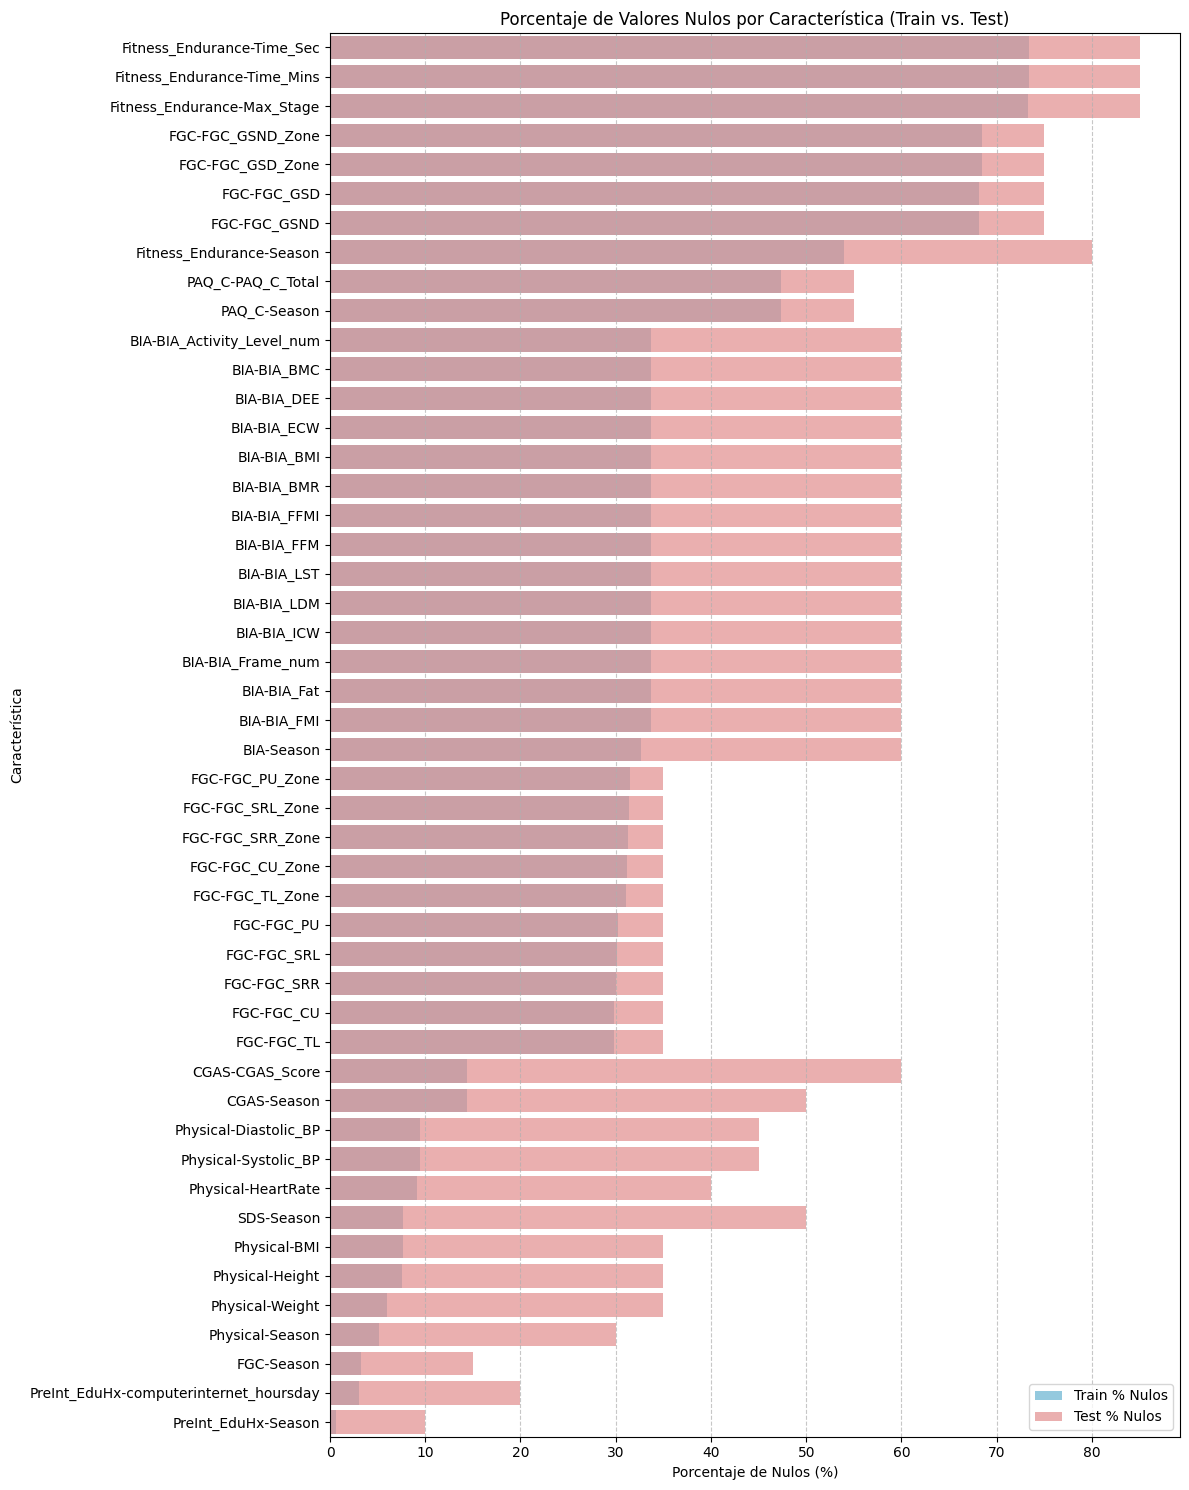


Transformadores de preprocesamiento definidos y agrupados en ColumnTransformer.


In [12]:
# Parte 3: Preprocesamiento Detallado y Pipeline

print("\n--- Preparando el Preprocesamiento Detallado y el Pipeline ---")

# Identificar columnas numéricas y categóricas finales
# Usamos X_train porque ya contiene las columnas limpias y finales
numeric_features = X_train.select_dtypes(include=np.number).columns.tolist()
categorical_features = X_train.select_dtypes(include='object').columns.tolist()

print(f"\nColumnas numéricas finales para preprocesamiento ({len(numeric_features)}):")
print(numeric_features)
print(f"\nColumnas categóricas finales para preprocesamiento ({len(categorical_features)}):")
print(categorical_features)

# --- Visualización 3: Valores Nulos por Característica (Top N) ---
# Consolidar nulos de X_train y X_test para ver la extensión del problema
# Para una mejor visualización, combinamos los nulos de ambos conjuntos (en sus columnas finales)
missing_train = X_train.isnull().sum()
missing_test = X_test.isnull().sum()

# Calcular el porcentaje de nulos
missing_train_percent = (missing_train / len(X_train)) * 100
missing_test_percent = (missing_test / len(X_test)) * 100

# Crear un DataFrame para la visualización
missing_data_df = pd.DataFrame({
    'Característica': missing_train_percent.index,
    'Train_Nulos_Porcentaje': missing_train_percent.values,
    'Test_Nulos_Porcentaje': missing_test_percent.values
})

# Filtrar solo las características con nulos en al menos un conjunto
missing_data_df = missing_data_df[(missing_data_df['Train_Nulos_Porcentaje'] > 0) |
                                  (missing_data_df['Test_Nulos_Porcentaje'] > 0)]

# Ordenar para visualizar las que tienen más nulos
missing_data_df = missing_data_df.sort_values(by='Train_Nulos_Porcentaje', ascending=False)

if not missing_data_df.empty:
    plt.figure(figsize=(12, min(len(missing_data_df) * 0.5, 15))) # Ajusta el tamaño dinámicamente
    bar_width = 0.35
    index = np.arange(len(missing_data_df))

    # Crear subplots para Train y Test si quieres barras separadas o combinarlas
    # Optaremos por una sola barra con ambos porcentajes en el label
    sns.barplot(x='Train_Nulos_Porcentaje', y='Característica', data=missing_data_df, color='skyblue', label='Train % Nulos')
    sns.barplot(x='Test_Nulos_Porcentaje', y='Característica', data=missing_data_df, color='lightcoral', label='Test % Nulos', alpha=0.7)

    plt.title('Porcentaje de Valores Nulos por Característica (Train vs. Test)')
    plt.xlabel('Porcentaje de Nulos (%)')
    plt.ylabel('Característica')
    plt.legend()
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
else:
    print("\nNo hay valores nulos en las características seleccionadas.")


# --- Definir transformadores para el preprocesamiento ---
# Para columnas numéricas: imputar con la mediana (más robusta a outliers) y escalar
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Para columnas categóricas: imputar con la moda (más frecuente) y aplicar One-Hot Encoding
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore')) # handle_unknown='ignore' para nuevas categorías en test
])

# Crear un preprocesador usando ColumnTransformer
# Esto aplicará diferentes transformaciones a diferentes tipos de columnas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough' # Mantiene columnas no especificadas (útil si hay IDs que no se remueven temprano, aunque aquí ya lo hacemos)
)

print("\nTransformadores de preprocesamiento definidos y agrupados en ColumnTransformer.")

# Continuar con el resto del script en la siguiente parte

# Modelado, entrenamiento y evaluación #


--- Modelado y Entrenamiento ---
Pipeline completo (preprocesador + clasificador) definido.

Entrenando el modelo...
Modelo entrenado exitosamente.
Pipeline de predicción guardado como 'full_prediction_pipeline.pkl'.

--- Evaluación del Modelo ---
Realizando validación cruzada estratificada (5-fold) en el conjunto de entrenamiento...
Puntuaciones de precisión (accuracy) de validación cruzada por fold: [0.55291971 0.58866545 0.57221207 0.54844607 0.56672761]
Precisión promedio de validación cruzada: 0.5658
Desviación estándar de la precisión: 0.0144


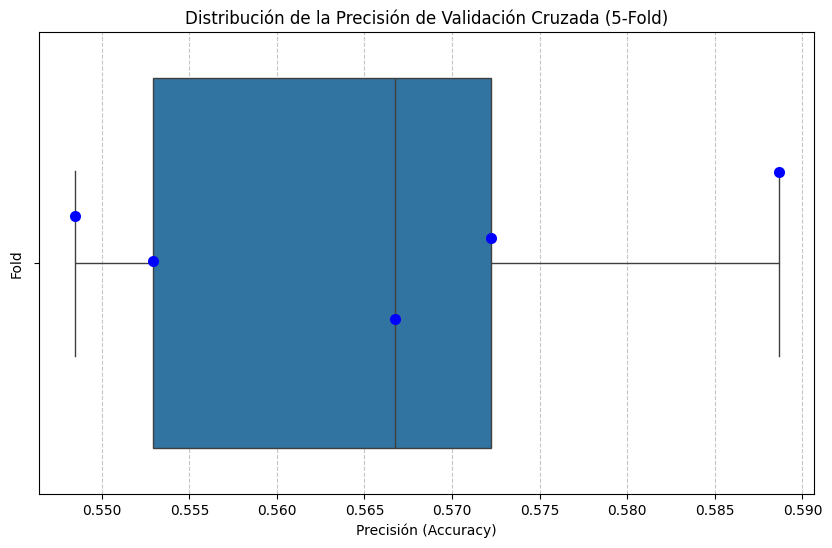


Generando métricas detalladas en un conjunto de validación (20% del X_train *limpio*)...
  (AVISO: `stratify=y_train` activado para esta evaluación detallada.)

--- Matriz de Confusión ---


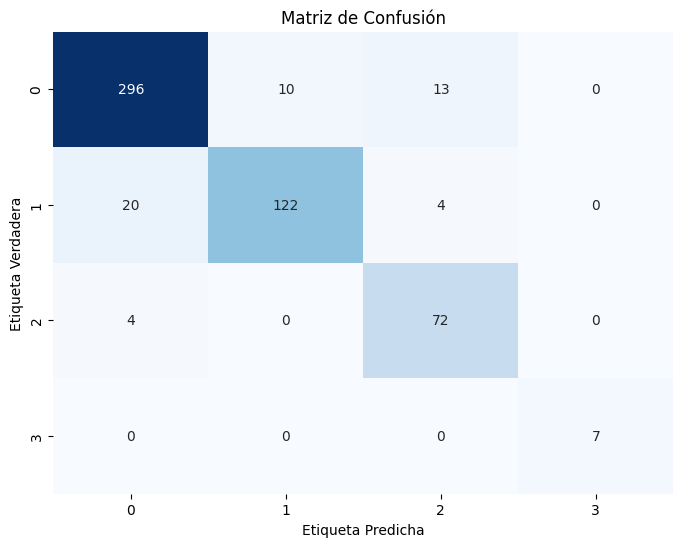


--- Reporte de Clasificación ---
              precision    recall  f1-score   support

           0       0.93      0.93      0.93       319
           1       0.92      0.84      0.88       146
           2       0.81      0.95      0.87        76
           3       1.00      1.00      1.00         7

    accuracy                           0.91       548
   macro avg       0.91      0.93      0.92       548
weighted avg       0.91      0.91      0.91       548


--- Precisión General (Accuracy) en el conjunto de validación: 0.9069 ---

--- Predicción en el Conjunto de Prueba y Exportación Final ---
Realizando predicciones en el conjunto de prueba (test_df)...
Archivo de envío 'submission.csv' creado exitosamente.
Primeras 5 filas del archivo de envío:
         id  sii
0  00008ff9    0
1  000fd460    0
2  00105258    0
3  00115b9f    1
4  0016bb22    2

--- Proceso Completo Finalizado ---


In [13]:
# Parte 4: Modelado, Entrenamiento y Evaluación

print("\n--- Modelado y Entrenamiento ---")

# Definir el clasificador (Random Forest con los parámetros ajustados)
# Incluimos max_depth para ayudar a prevenir el sobreajuste, como discutimos.
classifier = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced', max_depth=10)

# Crear el pipeline completo: preprocesador + clasificador
full_prediction_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                           ('classifier', classifier)])

print("Pipeline completo (preprocesador + clasificador) definido.")

print("\nEntrenando el modelo...")
# Entrenar el pipeline en el conjunto de entrenamiento limpio (X_train, y_train)
full_prediction_pipeline.fit(X_train, y_train)
print("Modelo entrenado exitosamente.")

# Guardar el pipeline entrenado
joblib.dump(full_prediction_pipeline, 'full_prediction_pipeline.pkl')
print("Pipeline de predicción guardado como 'full_prediction_pipeline.pkl'.")


print("\n--- Evaluación del Modelo ---")

# Realizando validación cruzada estratificada (para mantener las proporciones de clase)
# Usaremos StratifiedKFold para manejar el desequilibrio de clases
print("Realizando validación cruzada estratificada (5-fold) en el conjunto de entrenamiento...")
cv_folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(full_prediction_pipeline, X_train, y_train, cv=cv_folds, scoring='accuracy')

print(f"Puntuaciones de precisión (accuracy) de validación cruzada por fold: {cv_scores}")
print(f"Precisión promedio de validación cruzada: {np.mean(cv_scores):.4f}")
print(f"Desviación estándar de la precisión: {np.std(cv_scores):.4f}")

# --- Visualización 4: Resultados de la Validación Cruzada ---
plt.figure(figsize=(10, 6))
sns.boxplot(x=cv_scores)
sns.stripplot(x=cv_scores, color='blue', jitter=0.2, size=8)
plt.title('Distribución de la Precisión de Validación Cruzada (5-Fold)')
plt.xlabel('Precisión (Accuracy)')
plt.ylabel('Fold')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()


# Generando métricas detalladas en un conjunto de validación (20% del X_train *limpio*)
print("\nGenerando métricas detalladas en un conjunto de validación (20% del X_train *limpio*)...")
# Usaremos stratify=y_train aquí, ya que el max_depth en el RF debe evitar la memorización del 100%
# Y es una buena práctica para evaluaciones de un solo split en datasets desequilibrados.
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)
print("  (AVISO: `stratify=y_train` activado para esta evaluación detallada.)")


# Realizar predicciones en el conjunto de validación
y_pred_val = full_prediction_pipeline.predict(X_val_split)

# --- Visualización 5: Matriz de Confusión ---
print("\n--- Matriz de Confusión ---")
cm = confusion_matrix(y_val_split, y_pred_val)
class_labels = sorted(y_train.unique()) # Obtener las etiquetas de clase ordenadas

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=class_labels, yticklabels=class_labels)
plt.title('Matriz de Confusión')
plt.xlabel('Etiqueta Predicha')
plt.ylabel('Etiqueta Verdadera')
plt.show()

# --- Reporte de Clasificación ---
print("\n--- Reporte de Clasificación ---")
print(classification_report(y_val_split, y_pred_val, target_names=[str(c) for c in class_labels]))

# Precisión general en el conjunto de validación
val_accuracy = accuracy_score(y_val_split, y_pred_val)
print(f"\n--- Precisión General (Accuracy) en el conjunto de validación: {val_accuracy:.4f} ---")


print("\n--- Predicción en el Conjunto de Prueba y Exportación Final ---")
print("Realizando predicciones en el conjunto de prueba (test_df)...")

# Realizar predicciones en el conjunto de prueba
test_predictions = full_prediction_pipeline.predict(X_test)

# Crear el archivo de envío
submission_df = pd.DataFrame({'id': test_df['id'], 'sii': test_predictions})
submission_df['sii'] = submission_df['sii'].astype(int) # Asegurar que 'sii' sea tipo int

# Guardar el archivo de envío
submission_df.to_csv('submission.csv', index=False)
print("Archivo de envío 'submission.csv' creado exitosamente.")

print("Primeras 5 filas del archivo de envío:")
print(submission_df.head())

print("\n--- Proceso Completo Finalizado ---")